In [119]:
# # getting data
# import sys
# import os

# # getting the name of the directory where this file is present
# current = os.path.dirname(os.path.realpath('00_working_explore.ipynb'))

# # getting the parent directory
# parent = os.path.dirname(current)

# # adding the directory to the sys,path
# sys.path.append(parent)

from wrangle import get_clean_mac
from prepare_module import split_data, X_y_split

# getting exploration pmodules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# stats
from scipy import stats

# feature selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Exploration 1

## Initial Questions
Univariate Questions:
    * Which keyword has the most calls?
    * Which zipcodes?
    * Which subcategory?

* Request Amount:
    * Do the total amount of unresolved requests impact the response rating?
        * Does a keywords total amount of unresolved requests impact the response rating? Subcategory? Zipcode?

* Is there a relationship between zip codes and response times?
* Is there a relationship between keywords and response times?
* Is there a relationship between subcategories and response times?
* Is there a relationship beteen the number of open cases and response times?

In [15]:
def univariate_visulization(df):

    cat_cols, num_cols, td_cols = [], [], []
    
    for col in df.columns:
        if df[col].dtype == "O":
            cat_cols.append(col)
        
        elif df[col].dtype == "timedelta64[ns]":
            
            td_cols.append(col)
        
        else:
            if df[col].nunique() < 5:
                cat_cols.append(col)
            else:
                num_cols.append(col)
    explore_cols = cat_cols + num_cols + td_cols
    print(f'cat_cols: {cat_cols}')
    print(f'num_cols: {num_cols}')
    print(f'td_cols: {td_cols}')
    for col in explore_cols:
        if col in cat_cols:
            print(f'Univariate assessment of feature {col}:')
            sns.countplot(data=df, x=col, color='turquoise', edgecolor='black')
            plt.xticks(rotation=90)
            plt.show()
        if col in num_cols:
            print(f'Univariate feature analysis of feature {col}: ')
            plt.hist(df[col], color='turquoise', edgecolor='black')
            plt.xticks(rotation=90)
            plt.show()
            df[col].describe()
        if col in td_cols:
            print(f'Univariate feature analysis of feature {col}: ')
            plt.hist(df[col]/pd.Timedelta(days=1), color='turquoise', ec='black')
            plt.show()
            df[col].describe()
    print('_____________________________________________________')
    print('_____________________________________________________')
    print()

## Get wrangled data
The target variable is the the feature 'close_time' which is the amount of time it took to close the booking

In [2]:
# acquire data
df, train, validate, test = wrangle_data()

No stratification applied during the split


In [6]:
# quick examination of train
train.head()
# train.columns.values

,keyword,subcategory,incident_address,township,city,zip,council_district,created,last_modified,closed,...,percent_housing_occupancy_total_housing_units_vacant_housing_units_all_other_vacants,count_vacancy_rates_homeowner_vacancy_rate_(percent)_[4],count_vacancy_rates_rental_vacancy_rate_(percent)_[5],count_housing_tenure_occupied_housing_units,count_housing_tenure_occupied_housing_units_owner-occupied_housing_units,percent_housing_tenure_occupied_housing_units_owner-occupied_housing_units,count_housing_tenure_occupied_housing_units_renter-occupied_housing_units,percent_housing_tenure_occupied_housing_units_renter-occupied_housing_units,geography,geographic_area_name
66653,Chuckhole,Street (Chuckhole),914 E NEW YORK ST,CENTER,INDIANAPOLIS,46202,17.0,2018-06-07 12:19:35+00:00,2018-06-19 13:38:45+00:00,2018-06-19 13:38:44+00:00,...,2.6,5.1,9.9,11168,2863,25.6,8305,74.4,871Z200US1846202,"ZCTA5 46202, Indiana"
547293,Trash,Heavy,7419 E EDGEWOOD AVE,FRANKLIN,INDIANAPOLIS,46239,25.0,2019-11-15 21:34:41+00:00,2019-11-18 15:32:27+00:00,2019-11-18 15:32:25+00:00,...,1.0,0.8,6.9,11509,9236,80.3,2273,19.7,871Z200US1846239,"ZCTA5 46239, Indiana"
265669,Debris/Litter,Debris in Alley/Street,5905 BEAU JARDIN DR,FRANKLIN,INDIANAPOLIS,46237,18.0,2019-12-29 21:03:24+00:00,2020-05-19 17:45:35+00:00,2020-01-03 13:47:20+00:00,...,0.5,0.8,7.7,17188,11686,68.0,5502,32.0,871Z200US1846237,"ZCTA5 46237, Indiana"
493412,Chuckhole,Street (Chuckhole),215 S GERMAN CHURCH RD,WARREN,INDIANAPOLIS,46229,19.0,2019-02-13 01:15:17+00:00,2019-02-21 18:33:06+00:00,2019-02-21 18:33:05+00:00,...,0.8,1.2,8.8,11149,6255,56.1,4894,43.9,871Z200US1846229,"ZCTA5 46229, Indiana"
211240,Animal,Human Attack (Bite),5219 HONEY COMB LN,DECATUR,INDIANAPOLIS,46221,20.0,2017-04-17 13:42:10+00:00,2017-04-18 12:48:24+00:00,2017-04-18 12:48:19+00:00,...,2.4,1.3,8.9,10311,6270,60.8,4041,39.2,871Z200US1846221,"ZCTA5 46221, Indiana"


#### Note:
I may have bitten off more than i can chew
I will begin with only using the mac data and exploring those relationships first

## Mac Data exploration prep

In [2]:
# get data
df = get_clean_mac()

# split data
train, validate, test = split_data(df)


No stratification applied during the split


In [ ]:
train = train.drop('incident_address', axis=1)
# train = train.drop('state', axis=1)
univariate_visulization(train)
for col in train.columns:
    if train[col].dtype != 'O':
        print(col)

In [ ]:
print()
td = train['close_time'] 

# print(td)

td.astype('timedelta64[s]')

(td / pd.Timedelta(minutes=1)).hist()

# the very far ones are the open cases
# lets narrow and focus on the closed cses onluy

In [20]:
def remove_outliers(df, k=1.5):
    '''
    Actions: removies outliers using the IQR with a default k of 1.5
    '''
    # initialize dictionary
    col_qs = {}
    
    # assign column names to variable
    df_cols = df.columns
    
    # creates a list of column names
    df_cols = df_cols.to_list()
    
    # remove cat cols
    cat_cols = ['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district', 'status', 'origin']

    for col in cat_cols:
        df_cols.remove(col)

    # for each column
    for col in df_cols:
        
        # create qualtiles and put them in a dict
        col_qs[col] = q1, q3 = df[col].quantile([0.25, 0.75])

    # for each col
    for col in df_cols:    
        
        # calculate the iqr
        iqr = col_qs[col][0.75] - col_qs[col][0.25]
        
        # calculate the lower fence
        lower_fence = col_qs[col][0.25] - (iqr*k)
        
        # calculates the upper fence
        upper_fence = col_qs[col][0.75] + (iqr*k)
        
        # remove outliers from df for each column
        df = df[(df[col] > lower_fence) & (df[col] < upper_fence)]
        
    # exit df and return new df
    return df

In [22]:
remove_outliers(train).shape, train.shape

((425795, 12), (513312, 12))

In [28]:
for col in train.columns:
    if train[col].dtype == 'datetime64[ns, UTC]':
        print(col)

created
last_modified
closed


In [27]:
closed = train[train['status'] == 'Closed']

67887    12 days 01:19:09
560742    2 days 17:57:44
274255    4 days 16:43:56
505800    8 days 17:17:48
218087    0 days 23:06:09
               ...       
673173    1 days 02:09:22
928960    0 days 00:26:57
53807     3 days 05:59:18
722074    1 days 03:38:26
211520    5 days 15:42:16
Name: close_time, Length: 494104, dtype: timedelta64[ns]

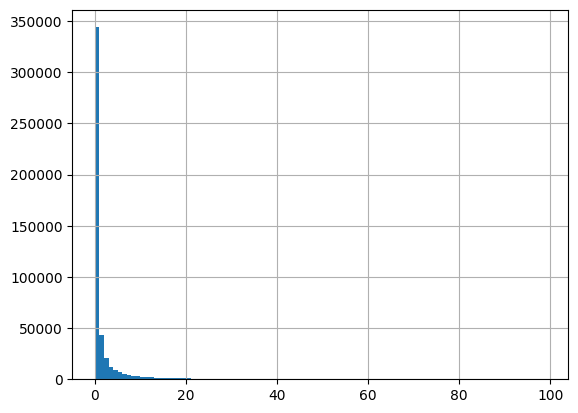

In [74]:
# the vast majority of items are resolved in a weekwith some even less days
(closed['close_time'].astype('timedelta64[s]') / pd.Timedelta(days=7)).hist(bins=range(0,100,1))

closed['close_time']

#### Notes:
* The vast majority of itenms and requests are resolved within a week, which is pretty good. The question is - what items are taking extremely long? Why is it taking so long?
* Next, it is time to get the questions for each category of group
* for this iteration of exploration - I iwll remain with a simple approach.
    * Drop all oother dattime items for the categorical exploration 
    * Explore to see if the time of year the request was created impacts the time it takes to resolve the issue. Lets replan and make a new game plan with all the questions that we want to explore

#### Actions:
 * Get initial questiosn written during the prep stage of the mac data
 * Focus on the closed status items only - i'm not sure how to handle the open ones yet som I will come back to that later

## MAC Cat Variable Exploration for Closed status

In [62]:
# preparing
# dropping the datetime stuff and only keeping the cat cols and the target
cat_cols = [col for col in closed.columns if closed[col].dtype == 'O' or col == 'close_time']

# checking columns
print(cat_cols,'\n\n',closed.columns)

# new df
closed_cat = closed[cat_cols]

# dropping status bc they are all closed
closed_cat = closed_cat.drop('status', axis=1)

['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district', 'status', 'origin', 'close_time'] 

 Index(['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district',
       'created', 'last_modified', 'closed', 'status', 'origin', 'close_time'],
      dtype='object')


cat_cols: ['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district', 'origin']
num_cols: []
td_cols: ['close_time']
Univariate assessment of feature keyword:


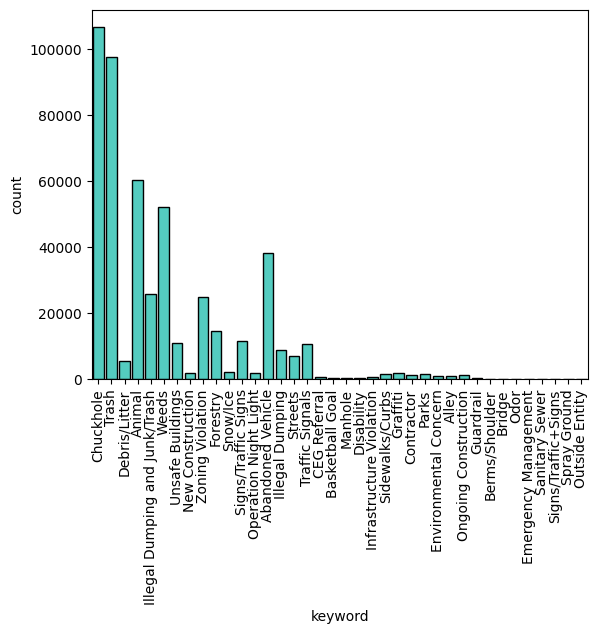

Univariate assessment of feature subcategory:


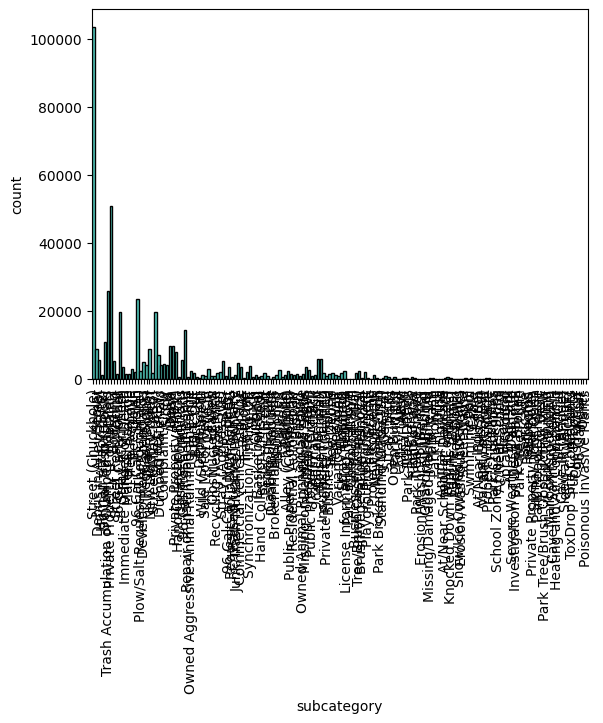

Univariate assessment of feature township:


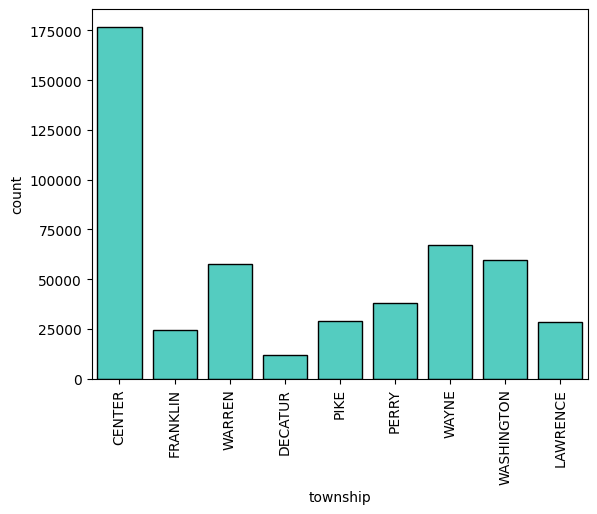

Univariate assessment of feature city:


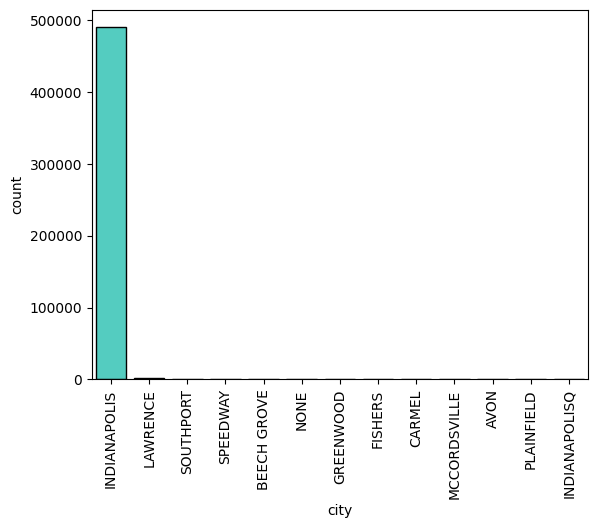

Univariate assessment of feature zip:


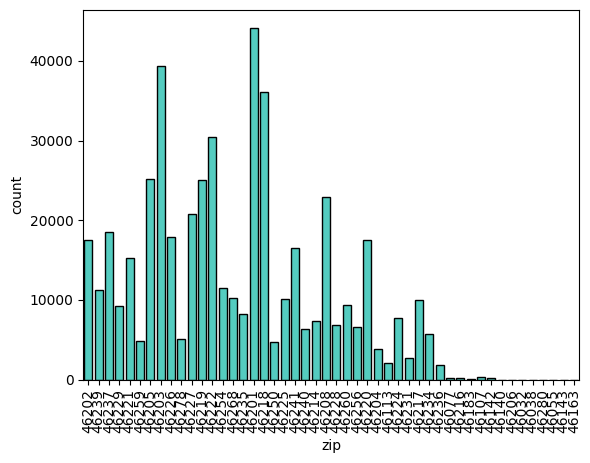

Univariate assessment of feature council_district:


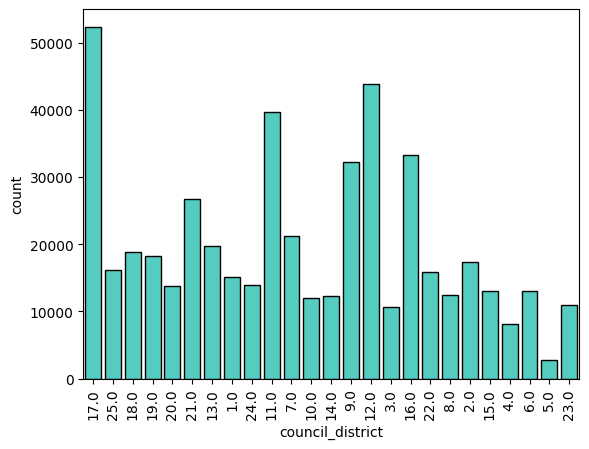

Univariate assessment of feature origin:


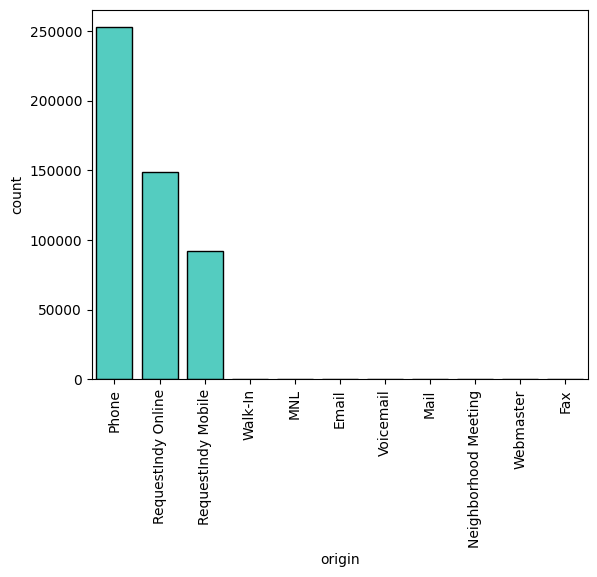

Univariate feature analysis of feature close_time: 


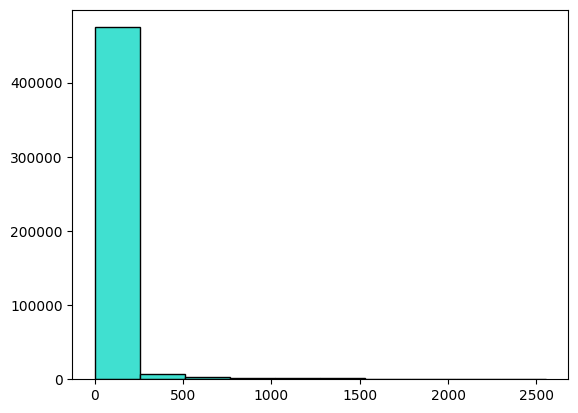

_____________________________________________________
_____________________________________________________



In [84]:
# hit the univariate again 
univariate_visulization(closed_cat)

 * Features/Variables:
    * ORIGIN: see if there is a relationship between origin and the time a service case is handled
    * STATUS:
        * Question: What proportion of each *category* is open/closed?
        * Question: What proportion of each *city* is open/closed?
        * Question: What proportion of each *township* is open/closed?
        * Question: What proportion of each *council district* is open/closed?
        * Question: What proportion of each *zip code* is open/closed?
    * Dates:
        * CLOSEDDATE: 
            * What are some reasons for the closed dates having (over 100) on one second? Is there a system wide update that occurs?
            * Is there a connection between the createddate and the closeddate?
        * CREATEDDATE: 
            * Why are there mulitple CREATEDDATE entries with the same second? Are there multiple categories of service frequests oin one call that are all inputed? Are these duplicates?
    * COUNCIL_DISTRICT__C
        * See how many districts there are and which districts have the best response times and worst response times
    * ZIP__C
        1. Make sure this is the zip code
        1. Get a csv file with the zipcode geometries in the states of indiana
        1. Merge the csv file with this data using the zipcode as the point of merging
        1. Use this to create a map of who has good time, who has bad response time, and whjo has great response times
     * CITY__C : 
        1. Change indianapolisq mispelling
        1. Investigate the 'NONE'
        1. Determine which has the fastest turnaround for non-emergency calls
        1. Does the Mayor Action thing apply to the other cities??
    * INCIDENT_ADDRESS__C
        * See if we can plot the incident addresses and identify the city for each 
        * Check to see whay some incidetn addressess have so many counts int he data
    * SUBCATEGORY__C:
        * Consolidate subcategories
        * If after consolidation , place all low couont subcategories into a new subcaegory called 'low_count_subcategories'
    * KEYWORD__C:
        1. Order all the key words alphabetically to check for duplicateswith similar spelling, see if it is intentional
        1. Within duplicates, ensure the subcategories are similary to the duplucatedones
    * SOURCE_ID__C
        * not very clear how this works. is there a list of source_id signifieers or a key that shows the meaning and significance of this information?
    * CASENUMBER:
        * Whya re there duplicate case numbers?

### Note: 
* It appears that I will need to create a level of delay to make this a classification problem for ease
* I will make 10 bins for each 10 percent for how long it takes


## Adding Response Rating as the new target
* this will allows statistical testing to be easier for me

In [99]:
# looking at the bins
print(pd.qcut(closed_cat['close_time'], 5).value_counts().sort_index())
print(pd.qcut(closed_cat['close_time'], 5, labels=['excellent', 'great', 'good', 'fair','poor']).value_counts().sort_index())
print()
print(pd.qcut(closed_cat['close_time'], 10).value_counts().sort_index())

close_time
(-1 days +23:59:59.999999999, 0 days 19:52:09.200000]    98821
(0 days 19:52:09.200000, 2 days 00:23:34.800000]         98821
(2 days 00:23:34.800000, 4 days 04:10:01]                98820
(4 days 04:10:01, 16 days 01:56:04.400000]               98821
(16 days 01:56:04.400000, 2553 days 18:04:17]            98821
Name: count, dtype: int64
close_time
excellent    98821
great        98821
good         98820
fair         98821
poor         98821
Name: count, dtype: int64

close_time
(-1 days +23:59:59.999999999, 0 days 04:40:35.300000]    49411
(0 days 04:40:35.300000, 0 days 19:52:09.200000]         49410
(0 days 19:52:09.200000, 1 days 02:47:16]                49412
(1 days 02:47:16, 2 days 00:23:34.800000]                49409
(2 days 00:23:34.800000, 3 days 13:35:26]                49410
(3 days 13:35:26, 4 days 04:10:01]                       49410
(4 days 04:10:01, 7 days 01:54:58.100000]                49411
(7 days 01:54:58.100000, 16 days 01:56:04.400000]        49410


In [100]:
# created the reponse rating
closed_cat['response_rating'] = pd.qcut(closed_cat['reponse_time'], 5, labels=['excellent', 'great', 'good', 'fair','poor'])

In [101]:
closed_cat

,keyword,subcategory,township,city,zip,council_district,origin,close_time,response_rating
67887,Chuckhole,Street (Chuckhole),CENTER,INDIANAPOLIS,46202,17.0,Phone,12 days 01:19:09,fair
560742,Trash,Heavy,FRANKLIN,INDIANAPOLIS,46239,25.0,Phone,2 days 17:57:44,good
274255,Debris/Litter,Debris in Alley/Street,FRANKLIN,INDIANAPOLIS,46237,18.0,RequestIndy Online,4 days 16:43:56,fair
505800,Chuckhole,Street (Chuckhole),WARREN,INDIANAPOLIS,46229,19.0,RequestIndy Online,8 days 17:17:48,fair
218087,Animal,Human Attack (Bite),DECATUR,INDIANAPOLIS,46221,20.0,Phone,0 days 23:06:09,great
...,...,...,...,...,...,...,...,...,...
673173,Animal,Abandoned,WARREN,INDIANAPOLIS,46229,19.0,Phone,1 days 02:09:22,great
928960,Animal,Noise (Animal),FRANKLIN,INDIANAPOLIS,46239,25.0,RequestIndy Online,0 days 00:26:57,excellent
53807,Trash,96 Gal Cart - Other,CENTER,INDIANAPOLIS,46208,7.0,Phone,3 days 05:59:18,good
722074,Trash,96 Gal Trash (Missed),WARREN,INDIANAPOLIS,46219,12.0,Phone,1 days 03:38:26,great


## Selectkbest scores
* I am focused on the categorical variabvles and the trget is categorical so the best stats test in theics case is a chi squared test. 
* The seldct k best will now be used
* Resources: 
    * [sklearn 6.3 Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features)
    * [How to Perform Feature Selection with Categorical Data](https://machinelearningmastery.com/feature-selection-with-categorical-data/)
    * [Feature Selection Techniques in Machine Learning with Python](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)
    * [LabelEncoder vs OrdinalEncoder](https://datascience.stackexchange.com/questions/39317/difference-between-ordinalencoder-and-labelencoder)

### Part 1 - old clean function

In [108]:
y_train = closed_cat['response_rating']
X_train = closed_cat.drop(['response_rating', 'close_time'], axis=1) 

In [110]:
# preparing the inputs or X
# create
oe = OrdinalEncoder()

# fit and transform
X_train_enc = oe.fit_transform(X_train)

In [113]:
# prepareing the outputs, targets or y
# create
le = LabelEncoder()

# fit and tranform it
y_train_enc = le.fit_transform(y_train)

['keyword', 'subcategory', 'township', 'zip']
Feature 0 164666.991473
Feature 1 325860.192338
Feature 2 4870.496785
Feature 3 1.387096
Feature 4 11416.022933
Feature 5 2171.494854
Feature 6 151.068414


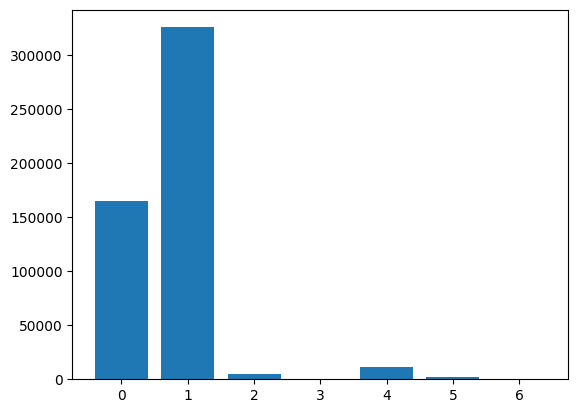

In [124]:
# getting the features
f_selector = SelectKBest(score_func=chi2, k=4)

# fittins
f_selector.fit(X_train_enc, y_train_enc)
# X_train_fs = f_selector.transform(X_train_enc)

fs_mask = f_selector.get_support()

print(X_train.iloc[:,fs_mask].columns.to_list())

for i in range(len(f_selector.scores_)):
    print('Feature %d %f' % (i, f_selector.scores_[i]))

plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.show()


### Part 2 - new clean function

#### Spliting

In [4]:
# getting new cleaned data
df = get_clean_mac()

In [3]:
## Created function below to stremline this process in the future and added it to prepare_module
# split
train, validate, test = split_data(df)

target = 'response_rating'

X_train, y_train = train.drop(target, axis=1), train[target]

X_validate, y_validate = validate.drop(target, axis=1), validate[target]

X_test, y_test = test.drop(target, axis=1), test[target]

Index(['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district',
       'created', 'last_modified', 'closed', 'origin', 'response_rating'],
      dtype='object')

In [5]:
# split all the data
train, validate, test,\
         X_train,y_train,\
             X_validate, y_validate,\
                  X_test, y_test = X_y_split(df, 'response_rating', stratify = True)

#### Endcoding

In [6]:
# encode_cat_features
# initialize and fit
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

oe.fit(X_train)

# transform
X_train_enc = oe.transform(X_train)
X_validate_enc = oe.transform(X_validate)
X_test_enc = oe.transform(X_test)

In [7]:
# encode_cat_target
#create and fit
le = LabelEncoder().fit(y_train)

# transform
y_train_enc = le.transform(y_train)
y_validate_enc = le.transform(y_validate)
y_test_enc = le.transform(y_test)

#### Selectkbest

In [8]:
# $ create
fs = SelectKBest(score_func=chi2, k=5)
# fit
fs.fit(X_train_enc, y_train_enc)
# transform
X_train_fs = fs.transform(X_train_enc)

print(X_train_enc.shape)
print(X_train_fs.shape)

(432858, 7)
(432858, 5)


Feature 0: 19893.802762
Feature 1: 56899.992635
Feature 2: 2831.275740
Feature 3: 0.412262
Feature 4: 7958.938268
Feature 5: 1217.221726
Feature 6: 32.660886


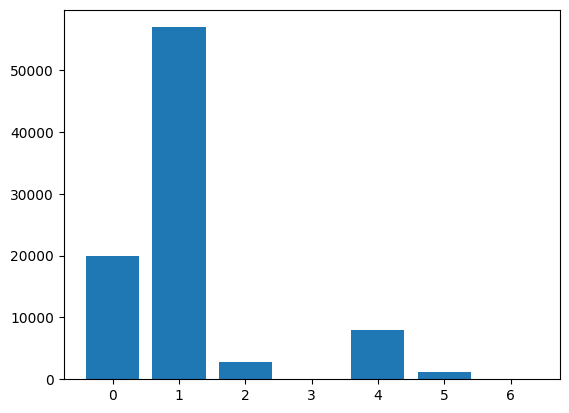

In [9]:
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [12]:
# get feature mask
mask = fs.get_support()
print(mask)

fs_columns = X_train.iloc[:, mask].columns.to_list()

[ True  True  True False  True  True False]


In [13]:
fs_columns

['keyword', 'subcategory', 'township', 'zip', 'council_district']

#### Notes:
* 'keyword', 'subcategory', 'township', 'zip', 'council_district' are the columns with the top relation hsipbs based on the chi2 testing
* Keyword and subcategory are directly related
* township, zip, and council district are all location based - with zip code being the smallest and having the strongest relationship
* I think keeping only the keyword, subcategory, and the zip code is the way to go - It may be useful to try to do some unsupervised clustering with the keywords - but I would like to clean up the key word subcategories if possible. 

#### Actions:
* Keyword - subcategory - in 00_working_prepare_mac notebook
    * Look into keywords
    * Look into each keywords subcategories
    * Identify similarities and necessary changes needed to make the subcategories make more sense
    * Conduct unsupervised clustering

# Exploration 2
* Make each class of the categorical variable a binary classification problem

## Get clean mac data

In [63]:
# getting clean data
file = '../data/Mayor_s_Action_Center_Service_Cases_Clean.csv'
df = pd.read_csv(file, index_col=0)

df = clean_mac_dtypes(df)

df['response_time_frame'] = df['response_time_frame'].str.replace('one', '1')

df.head()

,keyword,subcategory,township,city,zip,council_district,origin,num_open_cases,response_time_frame
0,Chuckhole,Street (Chuckhole),CENTER,INDIANAPOLIS,46225,16,RequestIndy Online,0,1 week
1,Weeds,Private Property (Complaint),CENTER,INDIANAPOLIS,46225,16,RequestIndy Online,1,1 week
2,Weeds,Private Property (Complaint),CENTER,INDIANAPOLIS,46225,16,RequestIndy Online,2,1 week
3,Weeds,Private Property (Complaint),CENTER,INDIANAPOLIS,46225,16,RequestIndy Online,3,1 week
4,Weeds,Private Property (Complaint),CENTER,INDIANAPOLIS,46225,16,RequestIndy Online,4,1 week


In [66]:
# splitting data
train, validate, test,\
     X_train,y_train,\
         X_validate, y_validate,\
              X_test, y_test = X_y_split(df, target = 'response_time_frame', stratify=True)

In [105]:
dummy_train = pd.concat([train, pd.get_dummies(train['response_time_frame'])], axis=1)

dummy_train.columns = dummy_train.columns.str.replace(' ', '_')
dummy_train.head()

,keyword,subcategory,township,city,zip,council_district,origin,num_open_cases,response_time_frame,1_week,2_weeks,3_weeks,4_weeks,5_weeks
597507,Abandoned Vehicle,Street/Alley (ABV),CENTER,INDIANAPOLIS,46208,11,Phone,3635,1 week,True,False,False,False,False
702043,Chuckhole,Street (Chuckhole),PIKE,INDIANAPOLIS,46278,1,RequestIndy Online,2063,4 weeks,False,False,False,True,False
217566,Abandoned Vehicle,Street (ABV),CENTER,INDIANAPOLIS,46202,17,RequestIndy Online,1273,1 week,True,False,False,False,False
145478,Trash,96 Gal Cart - Stolen,PERRY,INDIANAPOLIS,46227,16,Phone,761,1 week,True,False,False,False,False
126523,Weeds,Private Property (Complaint),CENTER,INDIANAPOLIS,46203,16,Phone,1067,1 week,True,False,False,False,False


## Univariate

In [28]:
univariate_visulization(df)

## Is there a relationship between zip codes and responding in a week?
- Which zip codes have the best average score?
- Whic zip codes have the worst average score?


### Count plots of zip and response time frame for each township

In [ ]:
# getting all of the respone types
# creating mask to reduce amoutn of information
mask = dummy_train['township'] == 'CENTER'

sns.catplot(data=dummy_train[mask].sort_values(by='response_time_frame'), y = 'zip', hue = 'response_time_frame', kind='count')

In [ ]:
# getting all the values for the townships 
township_list = list(train.township.unique())

for i in township_list:
    mask = train['township'] == i
    sns.catplot(data=train[mask].sort_values(by='response_time_frame'), y = 'zip', hue = 'response_time_frame', kind='count')
    plt.title(f'Zip Code Response Times for {i} township')
    plt.show()

#### Takeaways:
* There appear to be similar trends, with each zip code having the most closures within 1 week
* Few Counts:
    * Many of the zip codes have very few counts, so few that we cannot see them. This may warrant further investigation
    * Potential reasons: 
        1. those areas are less populated
        2. Those ares dont call - Why not? don't have time to follow that
    * There are too many unknown factor and I will need to continue
* A count representation is not as useful as the percentage of each. A stacked bar chart may be more useful.

#### Actions:
* Create a stacked bar chart to see if there is a large variation between 1,2,3,etc weeks

### Stacked Bar Chart of zip and response times by township

In [ ]:
# getting all the values for the townships 
township_list = list(train.township.unique())

for i in township_list:
    mask = train['township'] == i
    train.loc[mask].groupby(['zip', 'township'])['response_time_frame'].value_counts(normalize=True).mul(100).round(2).unstack().plot(kind='bar', stacked=True)

In [ ]:
data = pd.crosstab(mpg.model_decade, mpg['origin'])
sns.heatmap(data, annot=True, cmap=plt.cm.Greens)
data

### Relationship between zip codes and response time by township


In [ ]:
# getting all the values for the townships 
township_list = list(dummy_train.township.unique())

for i in township_list:
    print(i)
    mask = dummy_train['township'] == i

    sns.barplot(data=dummy_train.loc[mask], x='zip', y='1_week')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
sns.barplot(data=dummy_train, x='1_week', y='zip')
# plt.xticks(rotation=90)
plt.show()

### Stats

Null - zip code is independent of responding within a week
Alt - zip code is dependent on responding within a week

In [121]:
alpha = .05

observed = pd.crosstab(dummy_train['zip'], dummy_train['1_week'])
observed

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')



We reject the null hypothesis


## Is there a relationship between each keyword's subcategories and responding in a week?


In [ ]:
# how many cases were solved in a week for each subcategory
# getting the list of keywords to have a mask
keyword_list = list(dummy_train['keyword'].unique())

for i in keyword_list:
    mask = dummy_train['keyword'] == i
    sns.countplot()

In [ ]:
# not expansive enough, willdo a groupby instead
pd.crosstab(dummy_train[['keyword', 'subcategory', '1_week']]['subcategory'], dummy_train['1_week'])

In [ ]:
# getting the groupby cross tab
dummy_train.groupby('keyword')['subcategory'].value_counts()

In [ ]:
keyword_list = list(dummy_train['keyword'].unique())

for i in keyword_list:
    mask = dummy_train['keyword'] == i

    display(pd.crosstab(dummy_train.loc[mask]['subcategory'], dummy_train['1_week']))

/Users/aaron/codeup-data-science/env/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


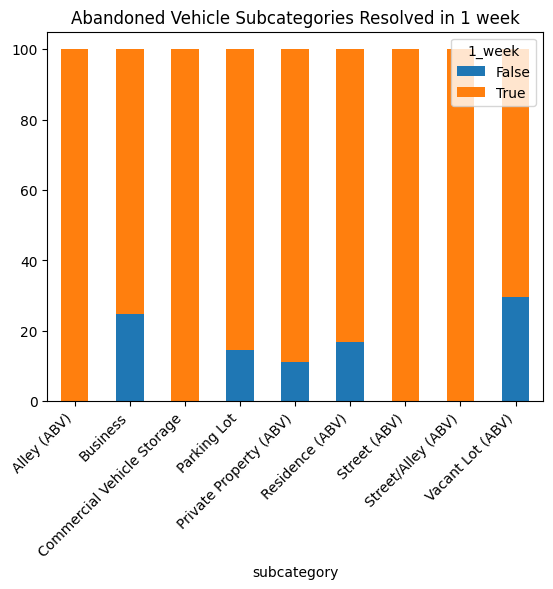

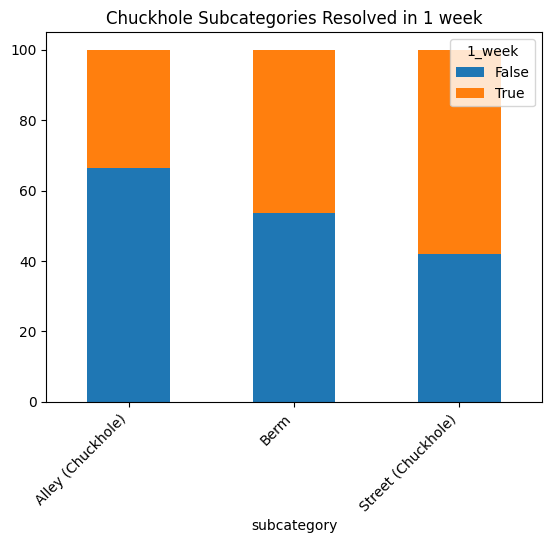

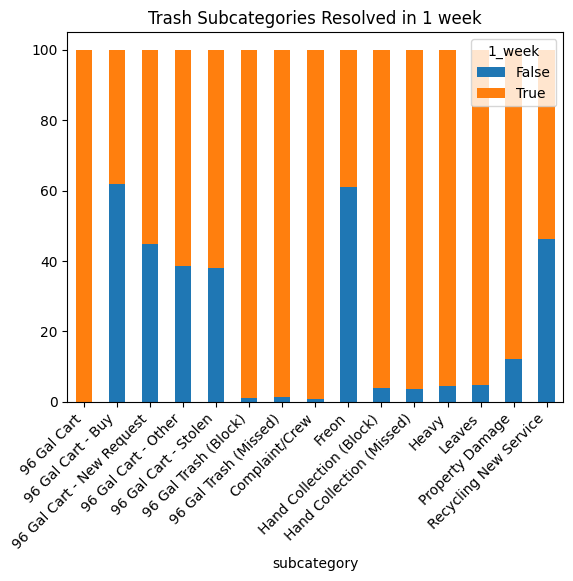

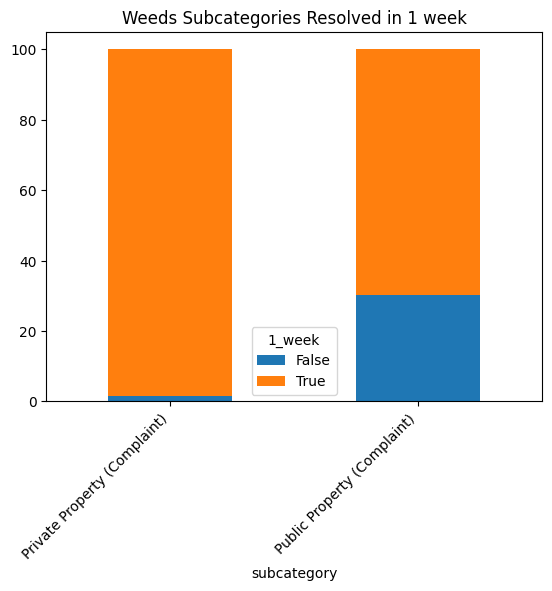

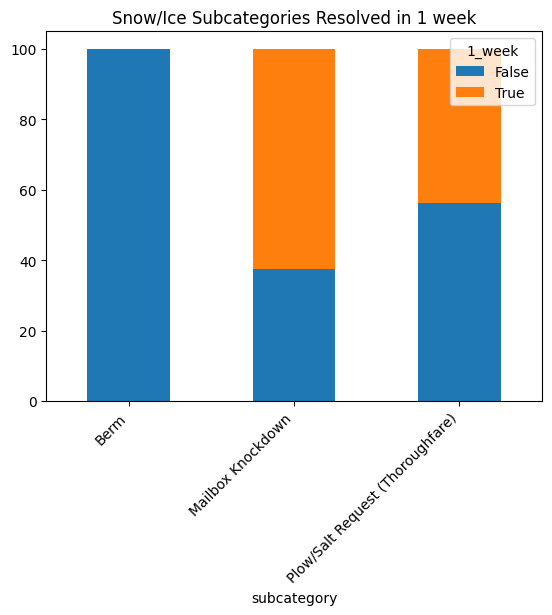

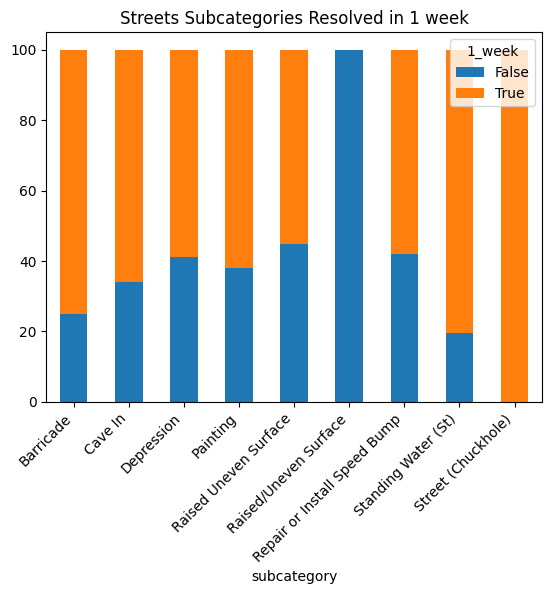

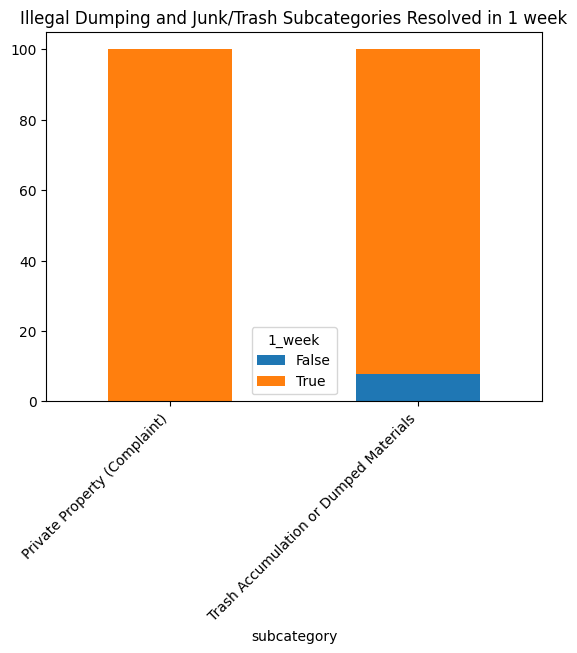

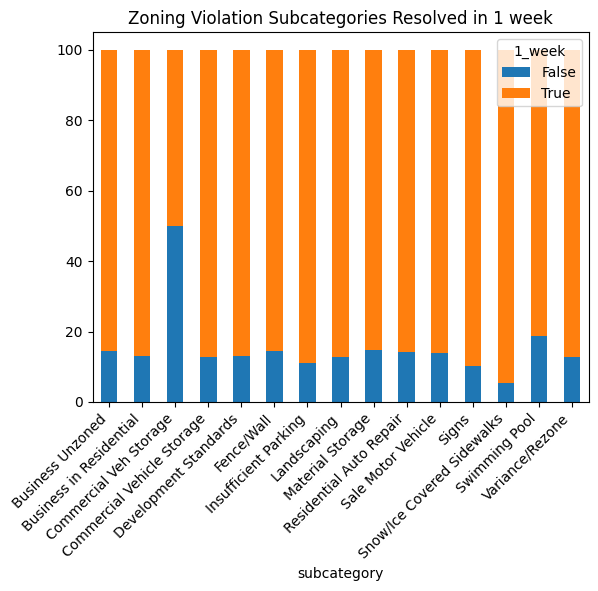

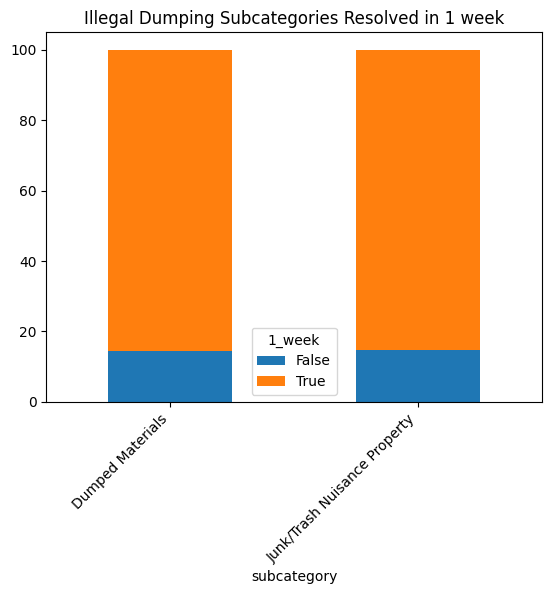

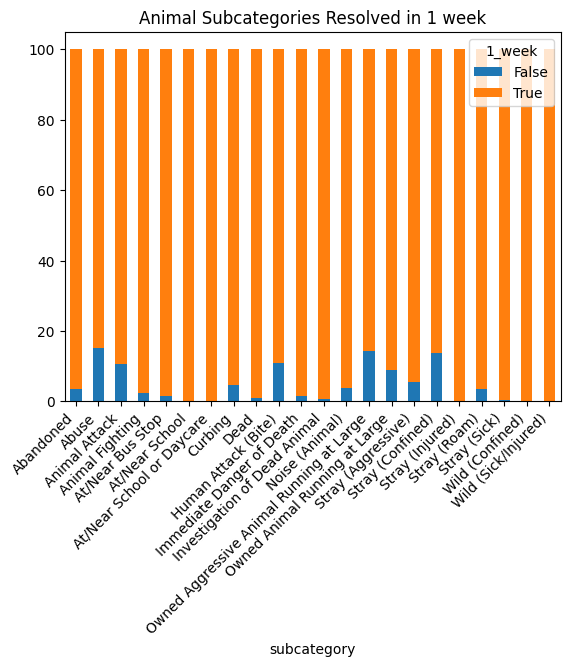

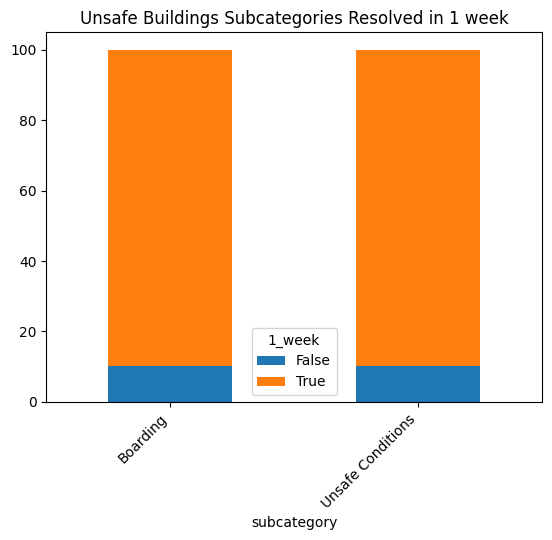

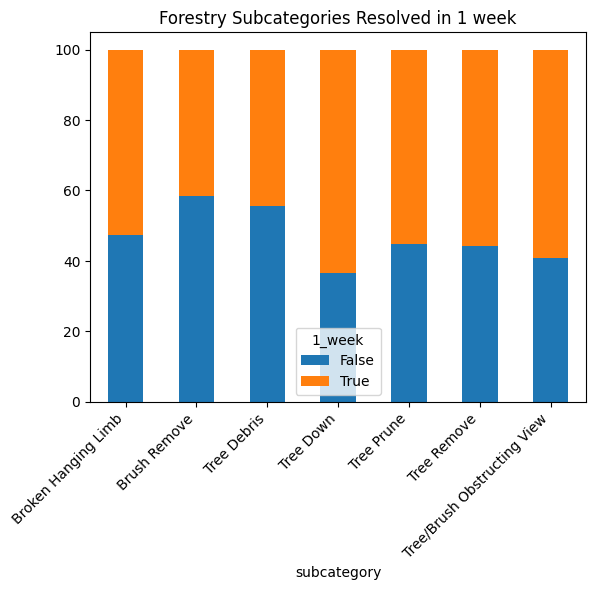

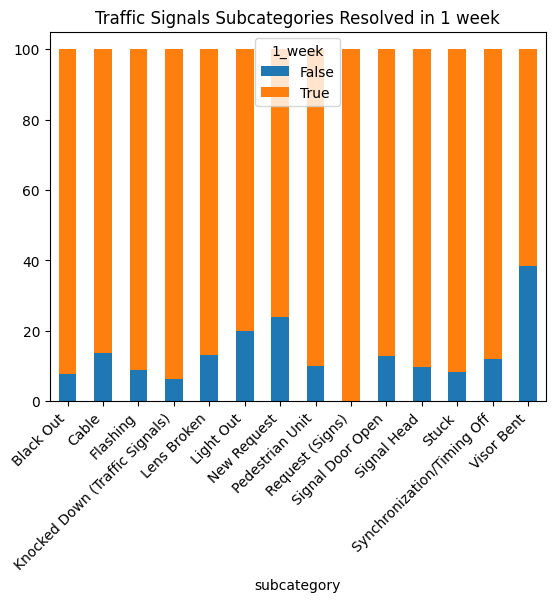

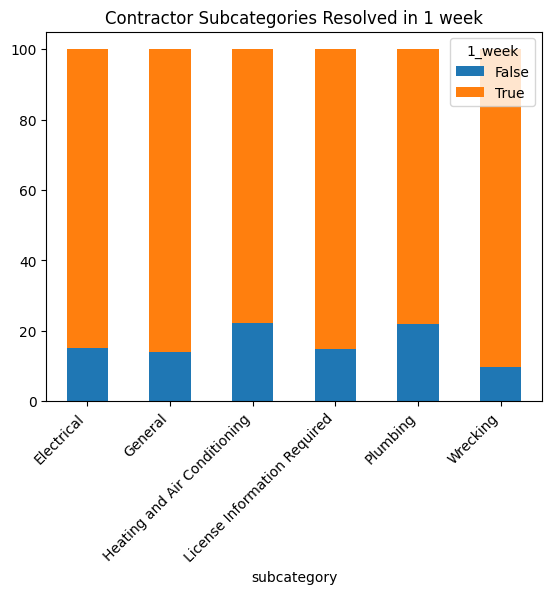

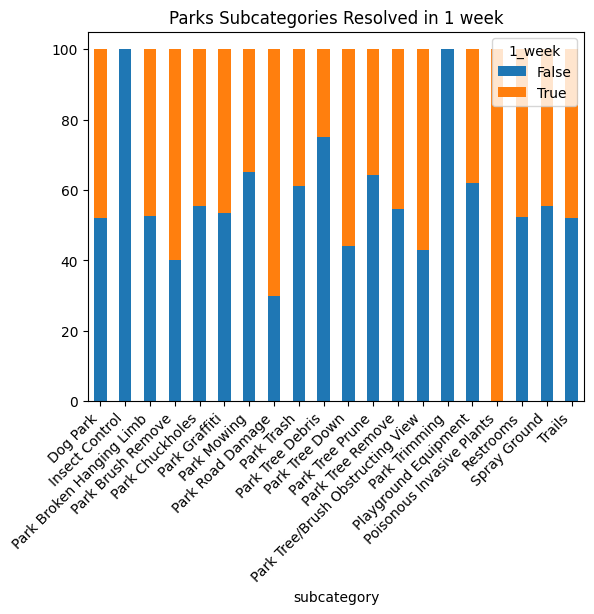

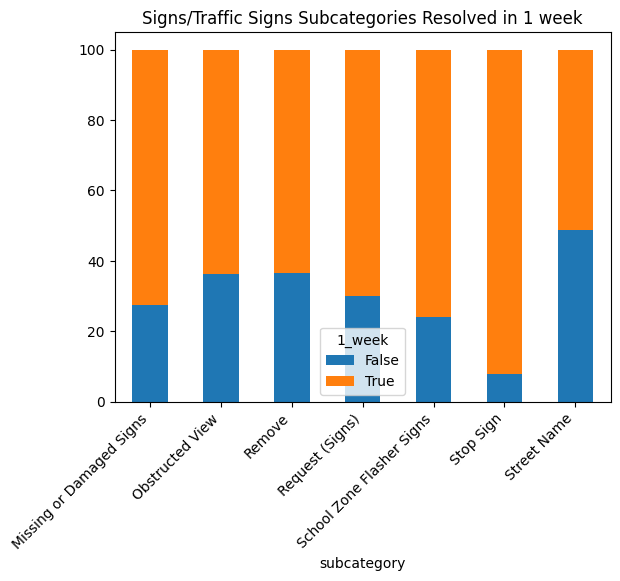

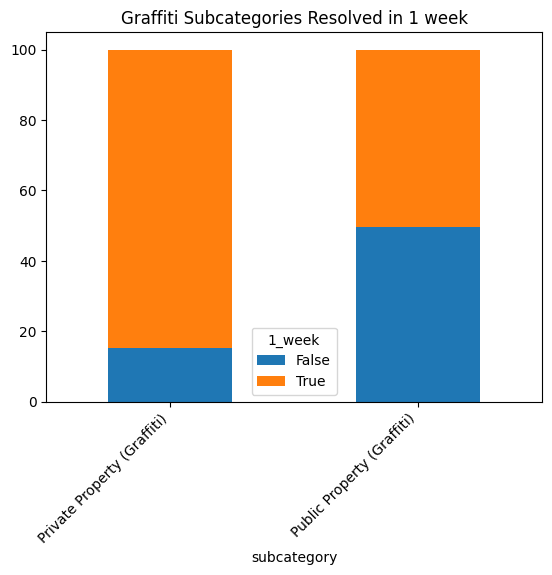

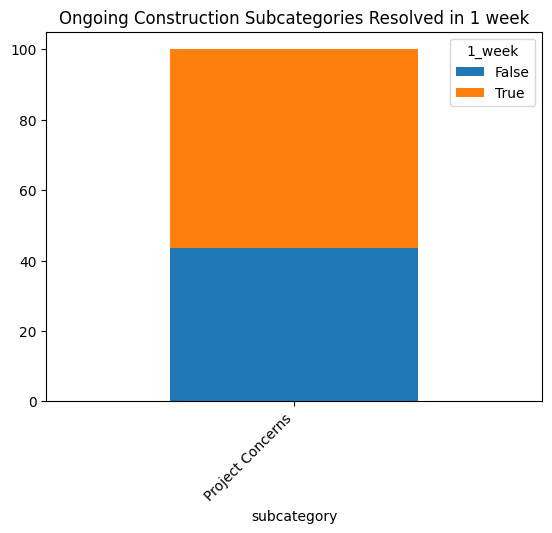

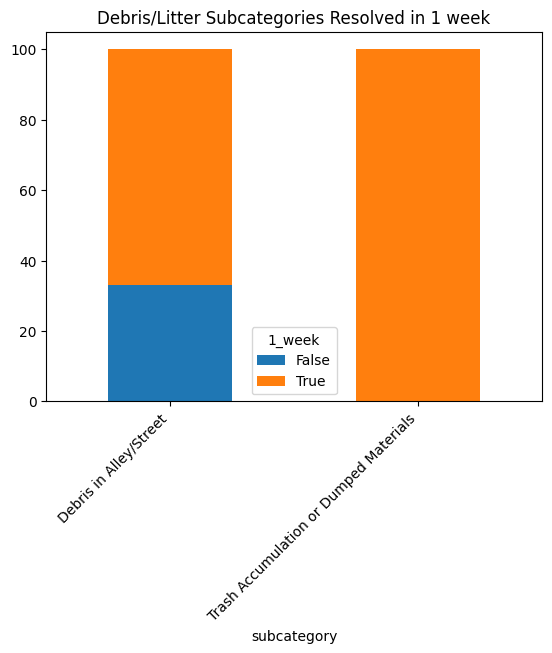

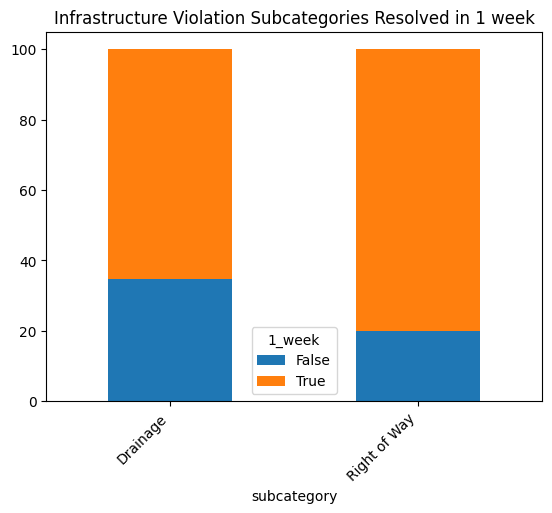

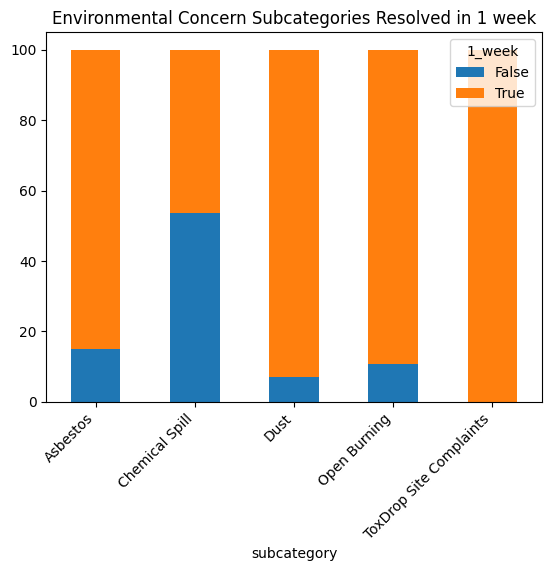

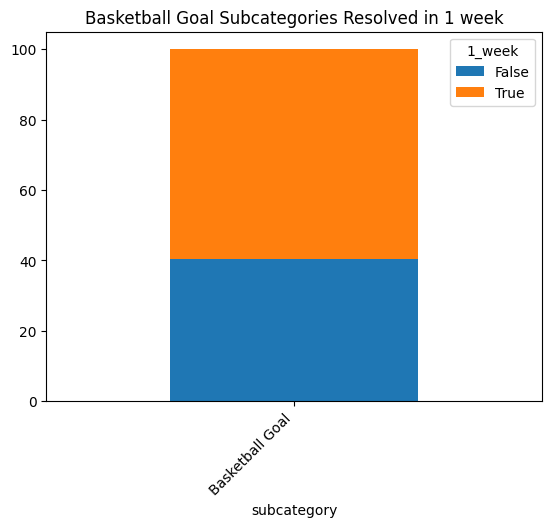

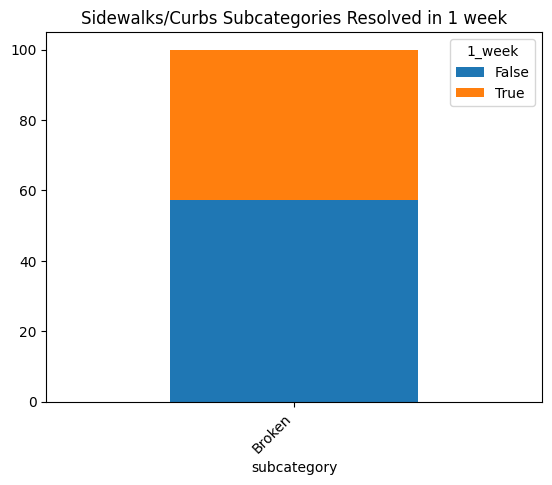

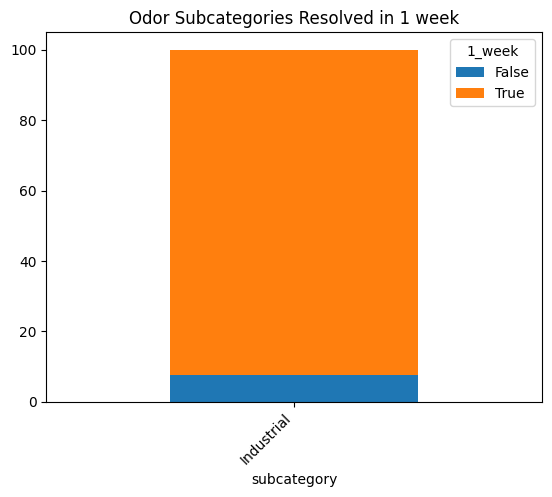

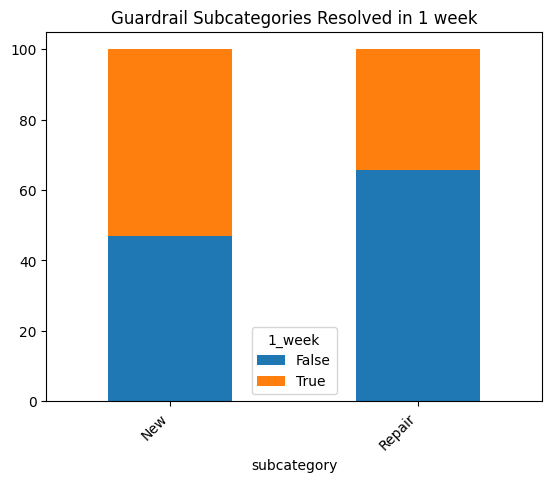

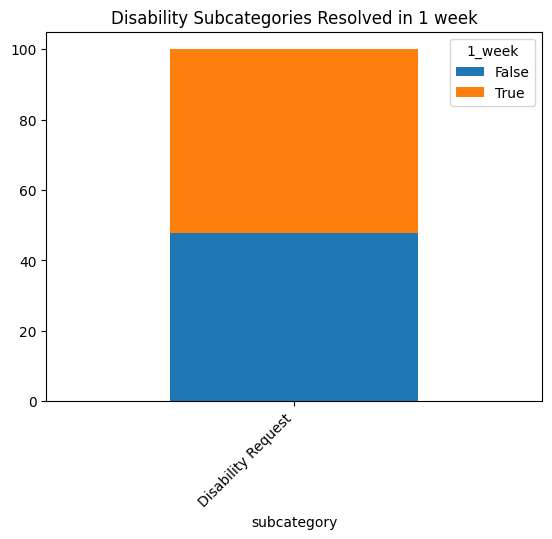

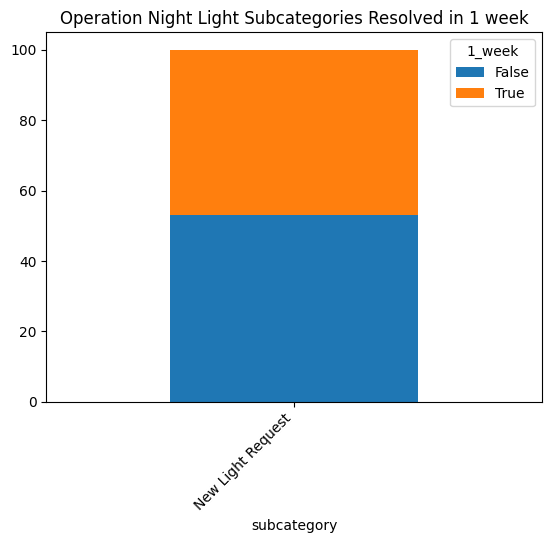

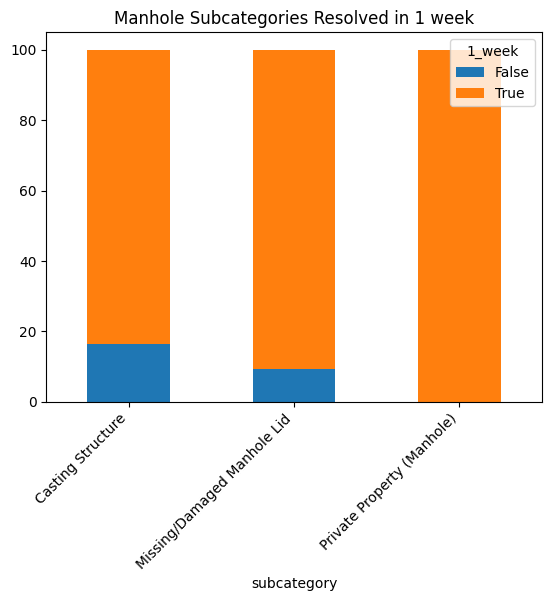

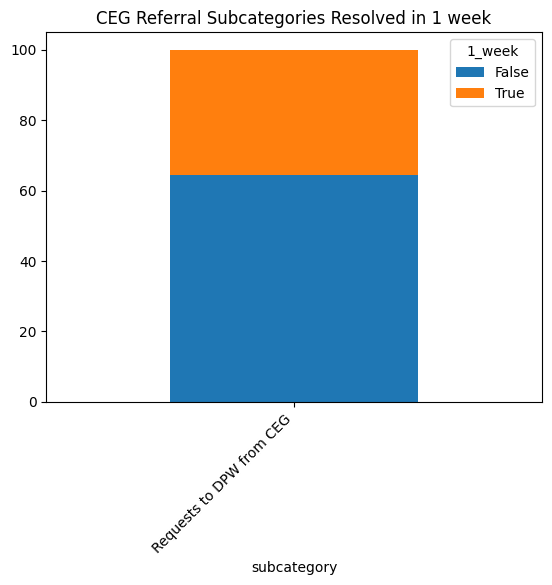

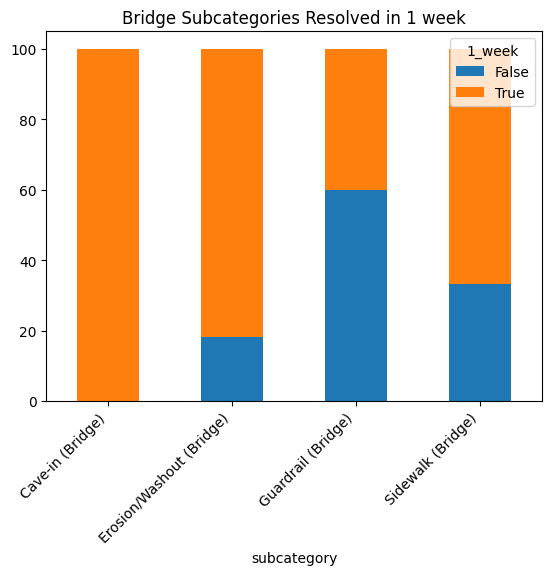

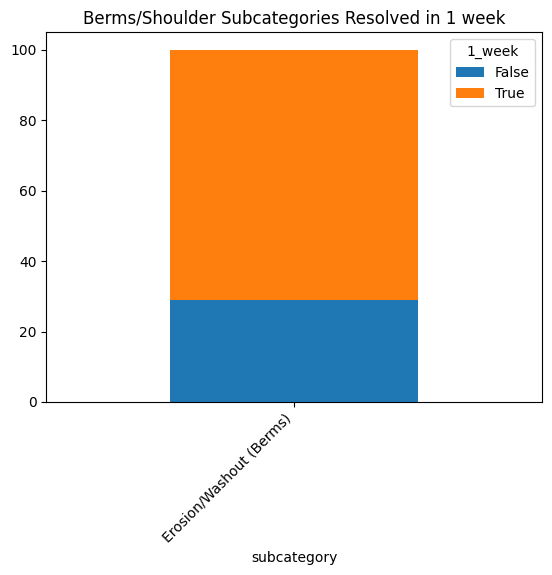

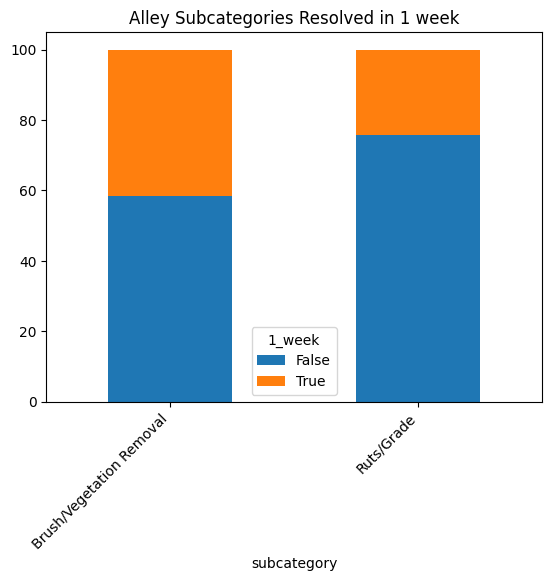

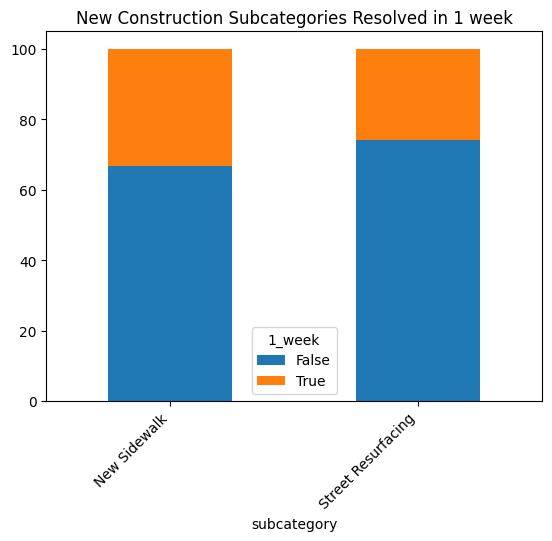

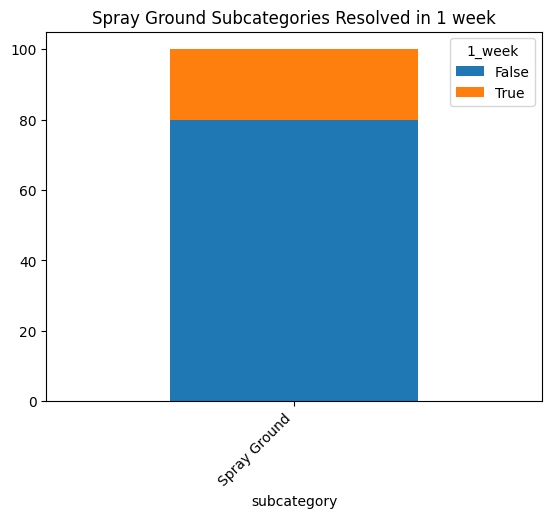

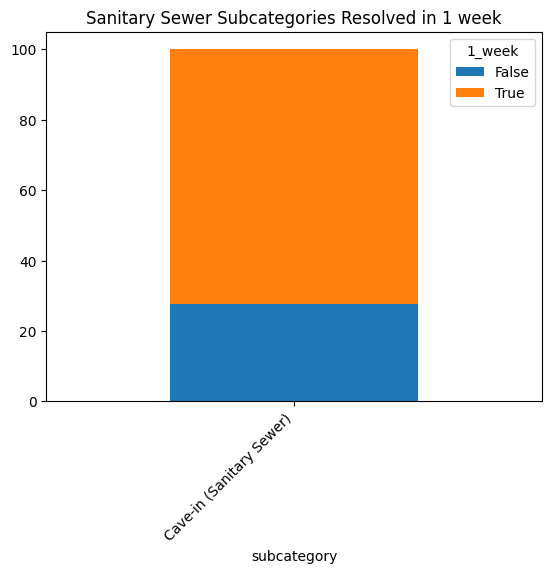

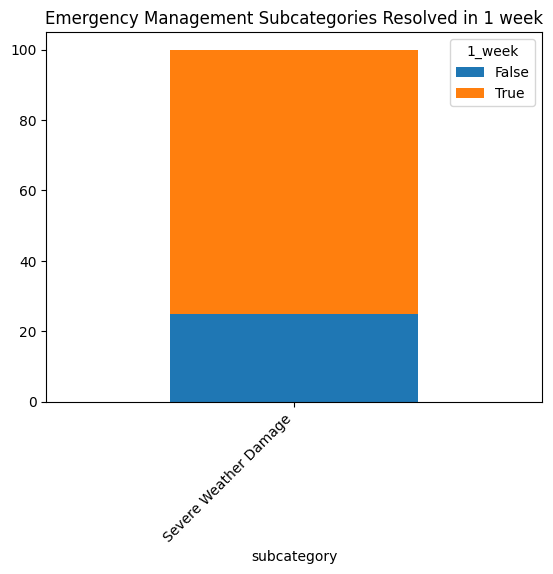

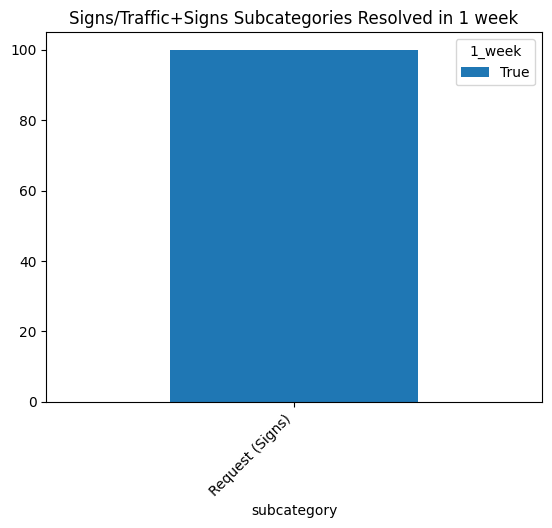

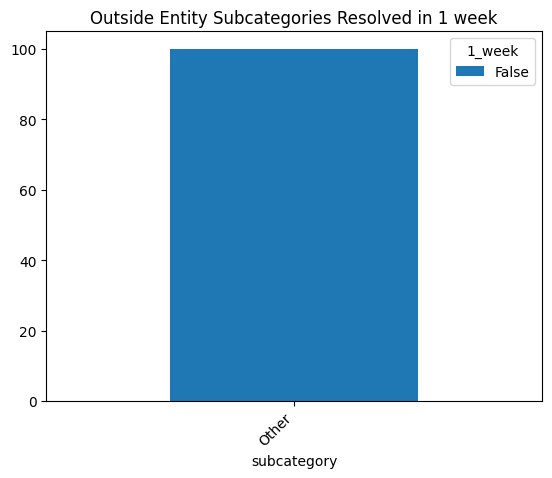

In [141]:
keyword_list = list(dummy_train['keyword'].unique())

for i in keyword_list:
    mask = dummy_train['keyword'] == i
    dummy_train.loc[mask].groupby(['subcategory'])['1_week'].value_counts(normalize=True).mul(100).round(2).unstack().plot(kind='bar', stacked=True)
    plt.xticks(rotation = 45, ha='right')
    plt.title(f'{i} Subcategories Resolved in 1 week')

## Is there a relationship beteen the number of open cases and responding in a week?

# Functions

## Preprocessing Functions

In [19]:
def X_y_split(df, target, stratify = False):
    '''
    This function takes a dataframe and splits it into the X and y train validate and test datasets
    Args:
        df : dataframe
        target : str, the y, or the output variable
        stratify : bool, stratify on the target | default:False
    Returns: train, validate, test,\
         X_train,y_train,\
             X_validate, y_validate,\
                  X_test, y_test 
    Modules:
        from prepare_module import split_data
        import pandas as pd
    '''
    # For stratification
    if stratify == True:

        # split the data witha  stratification on the target specified
        train, validate, test = split_data(df, stratify_on = target)
    
    # otherwise
    else:

        # split with no stratification
        train, validate, test = split_data(df)

    # isolate input and output data for train, validate, and test
    X_train, y_train = train.drop(target, axis=1), train[target]
    X_validate, y_validate = validate.drop(target, axis=1), validate[target]
    X_test, y_test = test.drop(target, axis=1), test[target]

    # print(X_train.shape[0] + y_train.shape[0] == train.shape[0], X_validate.shape[0] + y_validate.shape[0] == validate.shape[0], X_test.shape[0] + y_test.shape[0] == test.shape[0] )
    return train, validate, test,\
         X_train,y_train,\
             X_validate, y_validate,\
                  X_test, y_test 

In [10]:
# testing
train, validate, test,\
         X_train,y_train,\
             X_validate, y_validate,\
                  X_test, y_test  = X_y_split(df, 'response_rating')

No stratification applied during the split


In [23]:
def clean_mac_dtypes(df):
    '''
    Change the data type of council district and zip code to string object, change date columns to date time format
    '''   
    # changing dtype to string object
    df['council_district'] = df.council_district.astype(int).astype(str)
    df['zip'] = df.zip.astype(str)

    # changing multiple columns to date time dtype
    # df[['created','last_modified', 'closed']] = df[['created','last_modified', 'closed']].apply(pd.to_datetime)

    return df